In [36]:
import pandas as pd

# 데이터 불러오기
train = pd.read_csv('/Users/kimmandoo/Documents/GitHub/sw-ai-contest/data/raw/train.csv')
train

,title,full_text,generated
0,카호올라웨섬,카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5...,0
1,청색거성,"천문학에서 청색거성(靑色巨星, )은 광도 분류에서 III형(거성) 또는 II형(밝은...",0
2,엘자스-로트링겐 평의회 공화국,엘자스-로트링겐 평의회 공화국은 1차대전 말기 독일 혁명 와중에 엘자스-로트링겐에서...,0
3,윌리엄 페니 브룩스,"윌리엄 페니 브룩스(, 1809년 8월 13일 ~ 1895년 12월 11일)는 잉글...",0
4,미그로,"미그로 또는 미그로스(""Migros"")는 스위스 최대 소매 회사이자, 최대 슈퍼마켓...",0
...,...,...,...
97167,페르디난드 마젤란,"페르디난드 마젤란(, , , 1480년 봄 ~ 1521년 4월 27일)은 포르투갈 ...",0
97168,김용국 (만주보민회),"김용국(金用國, ? ~ ?)은 일제강점기에 만주보민회에서 활동했던 인물이다. \n ...",0
97169,알라 알사시,"알라 알사시(, 1987년 7월 2일 ~ )은 예멘의 축구 선수로 포지션은 공격형 ...",0
97170,전한 고제,패현(沛縣)의 정장(亭長)으로 있다가 진나라에 맞서는 봉기에 가담하고서 진의 수도 ...,0


### 1. 기본 통계 & 결측값, 중복값

In [20]:
print('라벨 분포')
print(train['generated'].value_counts())
print('\n결측치')
print(train.isnull().sum())
print('\n중복 텍스트 수:', train['full_text'].duplicated().sum())

라벨 분포
generated
0    89177
1     7995
Name: count, dtype: int64

결측치
title        0
full_text    0
generated    0
dtype: int64

중복 텍스트 수: 0


### 2. 텍스트 길이 분석

In [21]:
!pip install matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


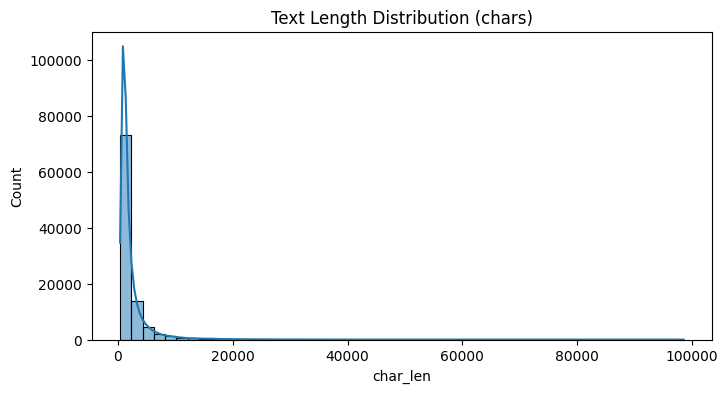

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train['char_len'] = train['full_text'].str.len()
plt.figure(figsize=(8,4))
sns.histplot(train['char_len'], bins=50, kde=True)
plt.title('Text Length Distribution (chars)')
plt.show()

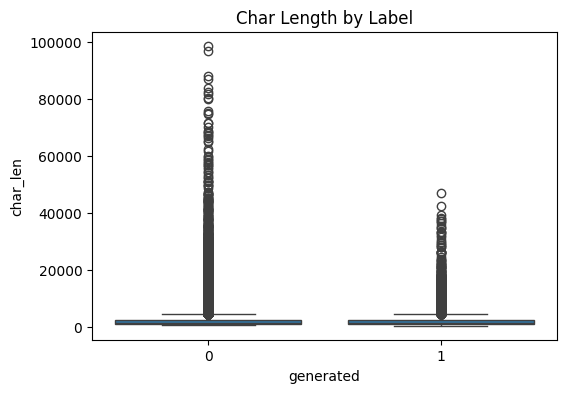

In [23]:
# 길이 by label
plt.figure(figsize=(6,4))
sns.boxplot(x='generated', y='char_len', data=train)
plt.title('Char Length by Label')
plt.show()

### 3. 문단 수 추정

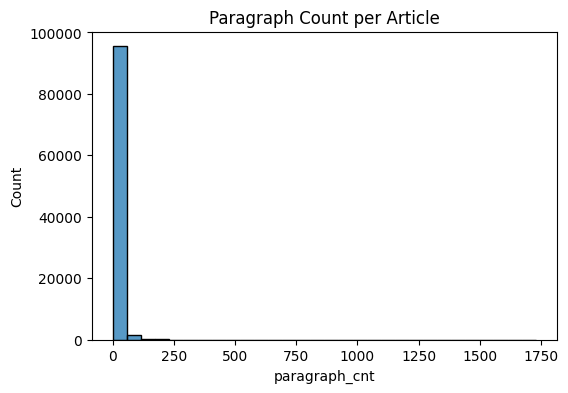

In [25]:
train['paragraph_cnt'] = train['full_text'].str.split('\n\n|\n').apply(len)
plt.figure(figsize=(6,4))
sns.histplot(train['paragraph_cnt'], bins=30)
plt.title('Paragraph Count per Article')
plt.show()

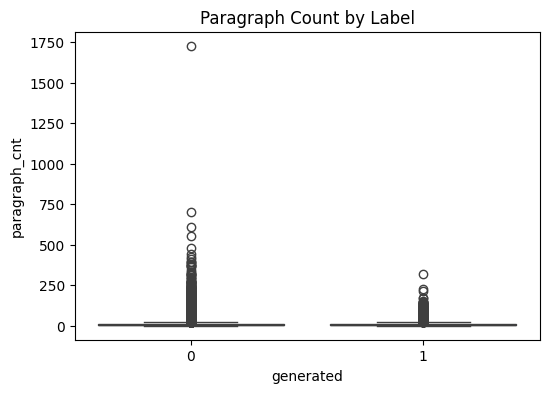

In [26]:
# 문단수 by label
plt.figure(figsize=(6,4))
sns.boxplot(x='generated', y='paragraph_cnt', data=train)
plt.title('Paragraph Count by Label')
plt.show()

### 4. 문장 수 추정 (간단 분할 기준)

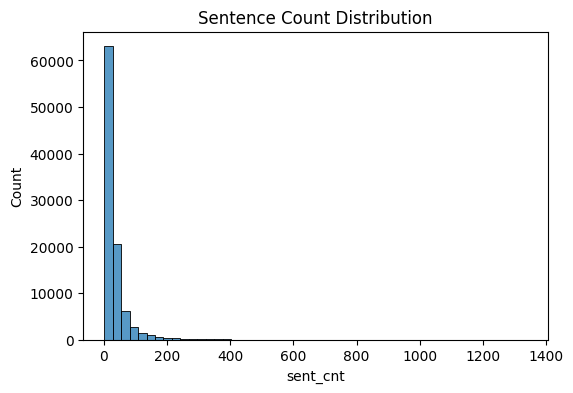

In [28]:
import re
sentence_split = re.compile(r'[.!?]\s')
train['sent_cnt'] = train['full_text'].apply(lambda x: len(sentence_split.split(x)))
plt.figure(figsize=(6,4))
sns.histplot(train['sent_cnt'], bins=50)
plt.title('Sentence Count Distribution')
plt.show()

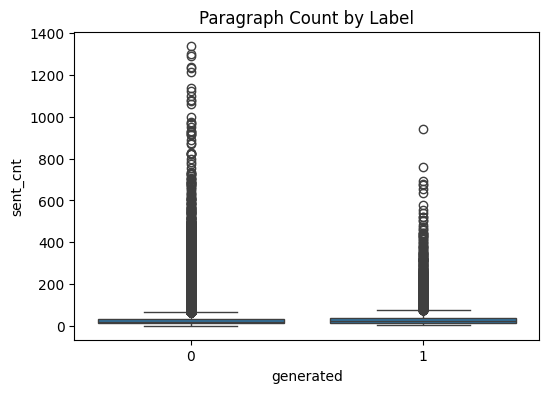

In [29]:
# 문장수 by label
plt.figure(figsize=(6,4))
sns.boxplot(x='generated', y='sent_cnt', data=train)
plt.title('Paragraph Count by Label')
plt.show()

### 5. 토큰 길이 분석 

Token indices sequence length is longer than the specified maximum sequence length for this model (1574 > 512). Running this sequence through the model will result in indexing errors


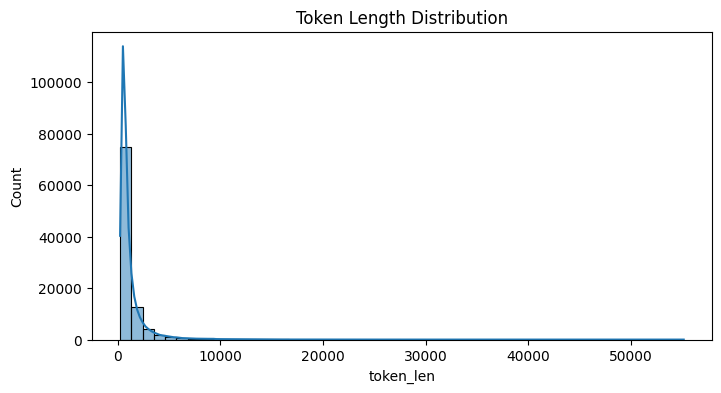

MAX token len: 55143


In [17]:
from transformers import AutoTokenizer

logger = print
MODEL_NAME = 'klue/bert-base'

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    train['token_len'] = train['full_text'].apply(lambda x: len(tokenizer(x, truncation=False)['input_ids']))
    plt.figure(figsize=(8,4))

    sns.histplot(train['token_len'], bins=50, kde=True)
    plt.title('Token Length Distribution')
    plt.show()
    print('MAX token len:', train['token_len'].max())
except Exception as e:
    logger.warning(f'Tokenizer 로드 실패: {e}')

### 6. 어휘 다양성 (TTR)

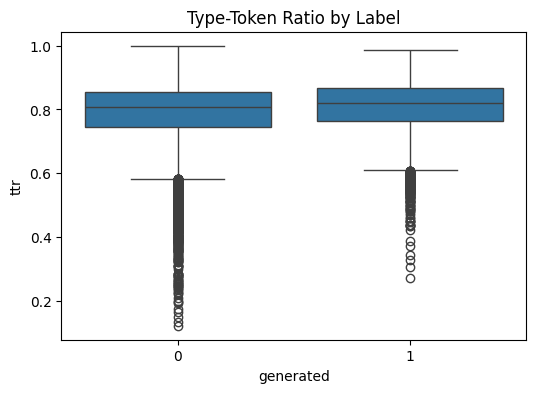

In [31]:
import re

tokenize_simple = lambda x: re.findall(r'\w+', x.lower())
train['ttr'] = train['full_text'].apply(lambda x: len(set(tokenize_simple(x))) / max(len(tokenize_simple(x)),1))
plt.figure(figsize=(6,4))
sns.boxplot(x='generated', y='ttr', data=train)
plt.title('Type-Token Ratio by Label')
plt.show()

In [33]:
for thr in [0.65, 0.70, 0.75, 0.80]:
    c = (train.assign(low=train["ttr"]<=thr)
             .groupby(["generated","low"])
             .size()
             .unstack(fill_value=0))
    pct = (c.div(c.sum(axis=1), axis=0)*100).round(2)
    print(f"\n=== threshold ≤ {thr} ===")
    display(pd.concat([c, pct.add_suffix('%')], axis=1))




=== threshold ≤ 0.65 ===


low,False,True,False%,True%
generated,,,,
0,83264,5913,93.37,6.63
1,7595,400,95.00,5.00



=== threshold ≤ 0.7 ===


low,False,True,False%,True%
generated,,,,
0,76973,12204,86.31,13.69
1,7140,855,89.31,10.69



=== threshold ≤ 0.75 ===


low,False,True,False%,True%
generated,,,,
0,65628,23549,73.59,26.41
1,6304,1691,78.85,21.15



=== threshold ≤ 0.8 ===


low,False,True,False%,True%
generated,,,,
0,47461,41716,53.22,46.78
1,4798,3197,60.01,39.99


### 7. 한자

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
print(tokenizer.tokenize("아령 (啞鈴) 또는 덤벨"))

['아', '##령', '(', '[UNK]', '[UNK]', ')', '또는', '덤', '##벨']


In [10]:
import re

train["has_hanja"] = train["full_text"].apply(lambda x: bool(re.search(r"[一-龥]", x)))
print(train[train["has_hanja"]]["generated"].value_counts())


generated
0    35822
1     2543
Name: count, dtype: int64


### 8. 외국어

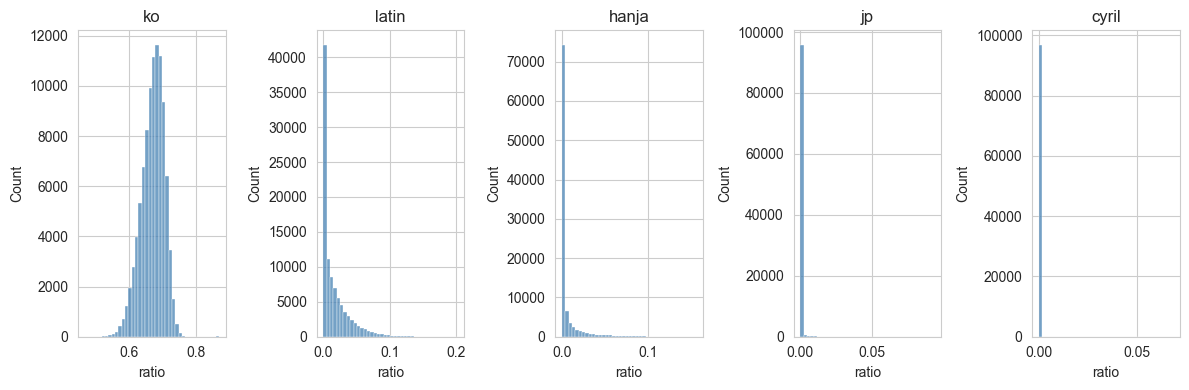

                ko                                                          \
             count    mean     std     min     25%     50%     75%     max   
generated                                                                    
0          89177.0  0.6691  0.0345  0.4655  0.6473  0.6729  0.6942  0.8704   
1           7995.0  0.6861  0.0311  0.5312  0.6667  0.6898  0.7088  0.7748   

             latin          ...   jp            cyril                         \
             count    mean  ...  75%     max    count mean     std  min  25%   
generated                   ...                                                
0          89177.0  0.0167  ...  0.0  0.0677  89177.0  0.0  0.0009  0.0  0.0   
1           7995.0  0.0143  ...  0.0  0.0941   7995.0  0.0  0.0007  0.0  0.0   

                             
           50%  75%     max  
generated                    
0          0.0  0.0  0.0683  
1          0.0  0.0  0.0409  

[2 rows x 40 columns]


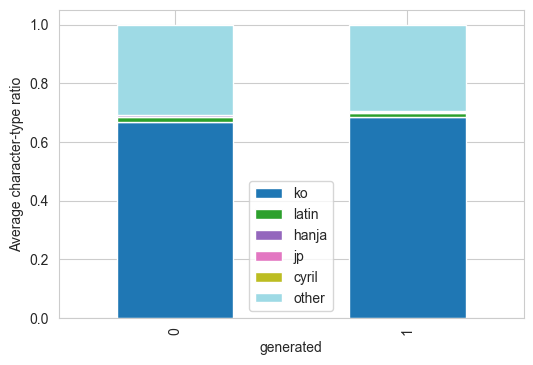

In [37]:
import re, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

# 유니코드 블록별 정규식
pat_ko      = r'[가-힣]'                     # 한글
pat_latin   = r'[A-Za-z]'                   # 라틴 알파벳(영, EU 언어 포함)
pat_hanja   = r'[\u4E00-\u9FFF]'            # CJK 통합 한자
pat_hira    = r'[\u3040-\u309F]'            # 히라가나
pat_kata    = r'[\u30A0-\u30FF]'            # 가타카나
pat_cyril   = r'[\u0400-\u04FF]'            # 키릴(러시아어권)

def char_block_ratio(text: str) -> dict:
    total = len(text)
    if total == 0:
        return {k:0 for k in
                ['ko','latin','hanja','jp','cyril','other']}
    
    cnt = lambda p: len(re.findall(p, text))
    
    ko    = cnt(pat_ko)
    latin = cnt(pat_latin)
    hanja = cnt(pat_hanja)
    jp    = cnt(pat_hira) + cnt(pat_kata)
    cyril = cnt(pat_cyril)
    
    other = total - (ko+latin+hanja+jp+cyril)
    return {
        'ko'   : ko   / total,
        'latin': latin/ total,
        'hanja': hanja/ total,
        'jp'   : jp   / total,
        'cyril': cyril/ total,
        'other': other/ total
    }

# 비율 컬럼 생성
ratio_df = train['full_text'].apply(char_block_ratio).apply(pd.Series)
train    = pd.concat([train, ratio_df], axis=1)

# 히스토그램
plt.figure(figsize=(12,4))
for i, col in enumerate(['ko','latin','hanja','jp','cyril']):
    plt.subplot(1,5,i+1)
    sns.histplot(train[col], bins=40, color='steelblue')
    plt.title(col)
    plt.xlabel('ratio')
plt.tight_layout(); plt.show()

# 라벨별 요약 통계
stats = (train.groupby('generated')
               [['ko','latin','hanja','jp','cyril']]
               .describe(percentiles=[.25,.5,.75])
               .round(4))
print(stats)

# 라벨별 평균
mean_by_lbl = train.groupby('generated')[
    ['ko','latin','hanja','jp','cyril','other']
].mean()

mean_by_lbl.plot(kind='bar', stacked=True,
                 figsize=(6,4), colormap='tab20')
plt.ylabel('Average character-type ratio'); plt.show()

